In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap
import seaborn as sn
import pandas as pd
import math
import random

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [77]:
# Change this if using cov matrix (or to keep the adjacency matrix)
is_cov = False

# Keep data in 2D for 2D convolution of the NN
def load_graphs(input_dir, class_dict) :

    data, data_labels = [], [] # data containing the graphs and data_labels the associated seizure type labels
    i=0
    for szr_type in class_dict.keys() :
        szr_label = class_dict[szr_type]
        for _, _, files in os.walk(os.path.join(input_dir,szr_type)) :
            for npy_file in files :
                A = np.load(os.path.join(input_dir,szr_type,npy_file))

                # Normalise A (already normalised depending on the input)
                A = A/np.amax(A.flatten())
                if is_cov : 
                    L = torch.tensor(A).view(1,20,20)
                else : 
                    L = torch.tensor(np.diag(A*np.ones((A.shape[0],1)))-A).view(1,20,20)
                    #L = torch.tensor(A).view(1,20,20)

                data.append(L)
                data_labels.append(szr_label)

    return np.array(data), np.array(data_labels)

def train_test_data(input_dir, class_dict) :

    train, train_labels = load_graphs(os.path.join(input_dir,'train'), class_dict)
    test, test_labels = load_graphs(os.path.join(input_dir,'dev'), class_dict)

    return train, test, train_labels, test_labels

In [78]:
# Need to put it as a torch.Size([1, 20, 20])
input_dir = '../data/v1.5.2/graph_unnormal'
#input_dir = '../data/v1.5.2/graph_cov_low'
#input_dir = '../data/v1.5.2/graph_avg_1_5'
szr_types = ['FNSZ','GNSZ']

class_dict = {}
for i, szr_type in enumerate(szr_types) :
    class_dict[szr_type] = i

train, test, train_labels, test_labels = train_test_data(input_dir, class_dict)

C:\Users\rapha\AppData\Local\Temp/ipykernel_19060/594653910.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(data), np.array(data_labels)
C:\Users\rapha\AppData\Local\Temp/ipykernel_19060/594653910.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), np.array(data_labels)


In [79]:
# Oversampling (train set only) to have balanced classification without dropping information
PD = pd.DataFrame(train_labels,columns=['label'])
no_0, no_1 = len(PD[PD['label']==0]), len(PD[PD['label']==1])
print(no_0, ' vs ', no_1)

R = math.floor(no_0/no_1)
print(R) # Multiply the dataset by this ratio, then add (no_0 - R*no_1) randomly selected entries from the smallest dataset
print(no_0 - R*no_1)

1536  vs  409
3
309


In [80]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset, testset = [], []
for i in range(len(train)) :
    if train_labels[i] == 1 : # Under-represented class :
        # The dataloader later shuffles the data
        for r in range(R) :
            trainset.append((train[i],train_labels[i]))
    else :
        trainset.append((train[i],train_labels[i]))

# Compensate the remaining imbalance => draw (no_0 - R*no_1) elements from already present elements
Add = random.sample(PD[PD['label']==1].index.to_list(),no_0 - R*no_1)
for idx in Add :
    trainset.append((train[idx],train_labels[idx]))

for j in range(len(test)) :
    testset.append((test[j],test_labels[j]))
classes = ('FNSZ','GNSZ')

#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [81]:
len(trainset)
tmp_set = []
for s in trainset :
    tmp_set.append(s[1])

PD_tmp = pd.DataFrame(tmp_set,columns=['label'])
tmp_0, tmp_1 = len(PD_tmp[PD_tmp['label']==0]), len(PD_tmp[PD_tmp['label']==1])
print(tmp_0, ' vs ', tmp_1)

1536  vs  1536


In [82]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 3 * 3, 80)
        self.fc2 = nn.Linear(80, 40)
        self.fc3 = nn.Linear(40, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim=1)

In [83]:
"""
class Net_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        print('Before : ',x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        print('After : ',x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

CNN = Net_2()
CNN = CNN.float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)
"""

"\nclass Net_2(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.fc1 = nn.Linear(16 * 5 * 5, 120)\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, 10)\n\n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(x)))\n        x = self.pool(F.relu(self.conv2(x)))\n        print('Before : ',x.shape)\n        x = torch.flatten(x, 1) # flatten all dimensions except batch\n        print('After : ',x.shape)\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n\nCNN = Net_2()\nCNN = CNN.float()\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.SGD(CNN.parameters(), lr=0.001, momentum=0.9)\n"

In [84]:
# Run forward pass once and check flattened output dimensions
CNN = Net()
CNN = CNN.float()
print(CNN)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=144, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=2, bias=True)
)


In [85]:
gamma = 1e-4
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNN.parameters(), lr=gamma)

In [86]:
total_L, total_acc = [], []
print('Batch_size : ',batch_size,'\nLearning rate : ',gamma)
for epoch in range(100): 
    i = 0
    temp_L = []

    correct = 0
    total = 0
    for data in trainloader:
        X, y = data
        optimizer.zero_grad()
        X, y = X.float(), y.type(torch.LongTensor)
        output = CNN(X)

        loss = loss_criterion(output, y)
        loss.backward()
        optimizer.step() 
        temp_L.append(loss)

        i += 1
    total_L.append(sum(temp_L)/float(len(temp_L)))
    print(f"Epoch : {epoch}, Loss : {round(total_L[-1].item(),6)}")
    #print('Accuracy of the network on the train graphs : %d %%' % (100 * correct / total))


Batch_size :  50 
Learning rate :  0.0001
Epoch : 0, Loss : 0.693594
Epoch : 1, Loss : 0.692251
Epoch : 2, Loss : 0.690419
Epoch : 3, Loss : 0.685889
Epoch : 4, Loss : 0.677099
Epoch : 5, Loss : 0.661829
Epoch : 6, Loss : 0.643356
Epoch : 7, Loss : 0.626734
Epoch : 8, Loss : 0.611697
Epoch : 9, Loss : 0.603025
Epoch : 10, Loss : 0.593427
Epoch : 11, Loss : 0.586065
Epoch : 12, Loss : 0.582786
Epoch : 13, Loss : 0.576218
Epoch : 14, Loss : 0.572474
Epoch : 15, Loss : 0.56908
Epoch : 16, Loss : 0.565468
Epoch : 17, Loss : 0.560396
Epoch : 18, Loss : 0.559726
Epoch : 19, Loss : 0.554732
Epoch : 20, Loss : 0.552052
Epoch : 21, Loss : 0.548845
Epoch : 22, Loss : 0.545382
Epoch : 23, Loss : 0.543209
Epoch : 24, Loss : 0.540686
Epoch : 25, Loss : 0.53674
Epoch : 26, Loss : 0.535319
Epoch : 27, Loss : 0.532447
Epoch : 28, Loss : 0.530586
Epoch : 29, Loss : 0.530235
Epoch : 30, Loss : 0.527501
Epoch : 31, Loss : 0.52459
Epoch : 32, Loss : 0.522907
Epoch : 33, Loss : 0.521982
Epoch : 34, Loss : 

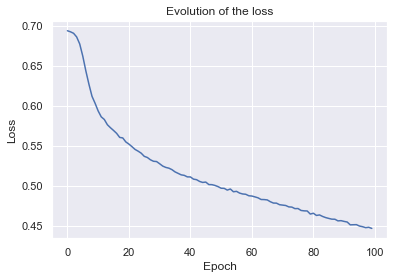

In [87]:
L_2 = [T.detach().numpy() for T in total_L]

L_2 = np.array(L_2)

plt.figure()
import seaborn as sns
sns.set()
plt.plot(L_2)
plt.title('Evolution of the loss')
plt.xlabel('Epoch');plt.ylabel('Loss');

In [88]:
correct = 0
total = 0

y_pred, y_true = [], []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        X_test, labels = data
        X_test, labels = X_test.float(), labels.type(torch.LongTensor)
        # calculate outputs by running images through the network
        outputs = CNN(X_test)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

TOT_ACC = 100 * correct / total
F1 = 100 * f1_score(y_true, y_pred, average='weighted')

print('Accuracy on test : %d %%' % (TOT_ACC))
print('Weighted F1-score on test : %d %%' % (F1))


Accuracy on test : 65 %
Weighted F1-score on test : 65 %


In [89]:
# prepare to count predictions for each class
classes = ('FNSZ','GNSZ')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        X_test, labels = data
        X_test, labels = X_test.float(), labels.type(torch.LongTensor)
        outputs = CNN(X_test)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


### DIVIDE BY TRUE TOTAL NB OF FNSZ & GNSZ

In [90]:
print('Final loss : ',round(total_L[-1].item(),6))
print(f'Unweighted total accuracy on test : {round(TOT_ACC,1)} %')
print(f'Weighted F1-score on test : {round(F1,1)} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for {:5s} is: {:.1f} %".format(classname, accuracy))

Final loss :  0.446736
Unweighted total accuracy on test : 65.4 %
Weighted F1-score on test : 65.9 %
Accuracy for FNSZ  is: 67.0 %
Accuracy for GNSZ  is: 62.6 %
